<a href="https://colab.research.google.com/github/Syed-MuhammadTaha/FacialRecognitionSiameseNetwork/blob/main/SiameseNetFacialRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Lambda, GlobalAveragePooling2D
from tensorflow.keras import Input, Model


In [ ]:
# import olivetti dataset form sklearn
from sklearn.datasets import fetch_olivetti_faces

In [ ]:
image_data = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


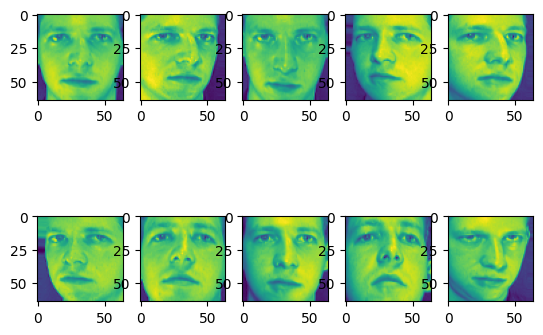

In [ ]:
# show images in grid like form
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(image_data.images[i])

In [ ]:
def base_model():
    inputs = Input((64, 64, 1))
    x = Conv2D(96, (11, 11), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (5, 5), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(384, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    flatten = Flatten()(x)
    dense = Dense(1024)(flatten)
    outputs = Dense(128)(dense)

    model = Model(inputs, outputs)
    return model

In [ ]:
model = base_model()
person1 =  Input((64, 64, 1))
person2 =  Input((64, 64, 1))

person1_output = model(person1)
person2_output = model(person2)

In [ ]:
def euclidean_dist(vector):
  person1_output, person2_output = vector
  return tf.reduce_sum(tf.square(person1_output - person2_output), axis=1, keepdims=True)

In [ ]:
lambda_layer = Lambda(euclidean_dist)([person1_output, person2_output])
output = Dense(1, activation="sigmoid")(lambda_layer)
model = Model([person1, person2], output)

In [ ]:
def generate_pairs(image_data, image_labels):
  pairs = []
  labels = []
  n_classes = len(np.unique(image_labels))
  for i in range(n_classes):
    indexes = np.where(image_labels == i)[0]
    for j in range(len(indexes) - 1):
      anchor = image_data[indexes[j]]
      positive = image_data[indexes[j + 1]]
      pairs.append([anchor, positive])
      labels.append(1)
      negative_indexes = np.where(image_labels != i)[0]
      random_index = np.random.choice(negative_indexes)
      negative = image_data[random_index]
      pairs.append([anchor, negative])
      labels.append(0)
  return np.array(pairs), np.array(labels)

In [ ]:
images_pair, labels_pair = generate_pairs(image_data.images, image_data.target)


In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
images_pair[:, 0].shape

(720, 64, 64)

In [ ]:
history = model.fit([images_pair[:, 0], images_pair[:, 1]], labels_pair[:],validation_split=0.1,batch_size=64,epochs=100)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5101 - loss: 0.8288 - val_accuracy: 0.7222 - val_loss: 0.6862
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - accuracy: 0.5053 - loss: 0.6517 - val_accuracy: 0.6389 - val_loss: 0.6371
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.5238 - loss: 0.6136 - val_accuracy: 0.6944 - val_loss: 0.6532
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.5594 - loss: 0.5914 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.6584 - loss: 0.6209 - val_accuracy: 0.7222 - val_loss: 0.6636
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.5259 - loss: 0.6017 - val_accuracy: 0.7639 - val_loss: 0.6315
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.5529 - loss: 0.5650 - val_accuracy: 0.7917 - val_loss: 0.6135
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.5627 - loss: 0.5637 - val_accur

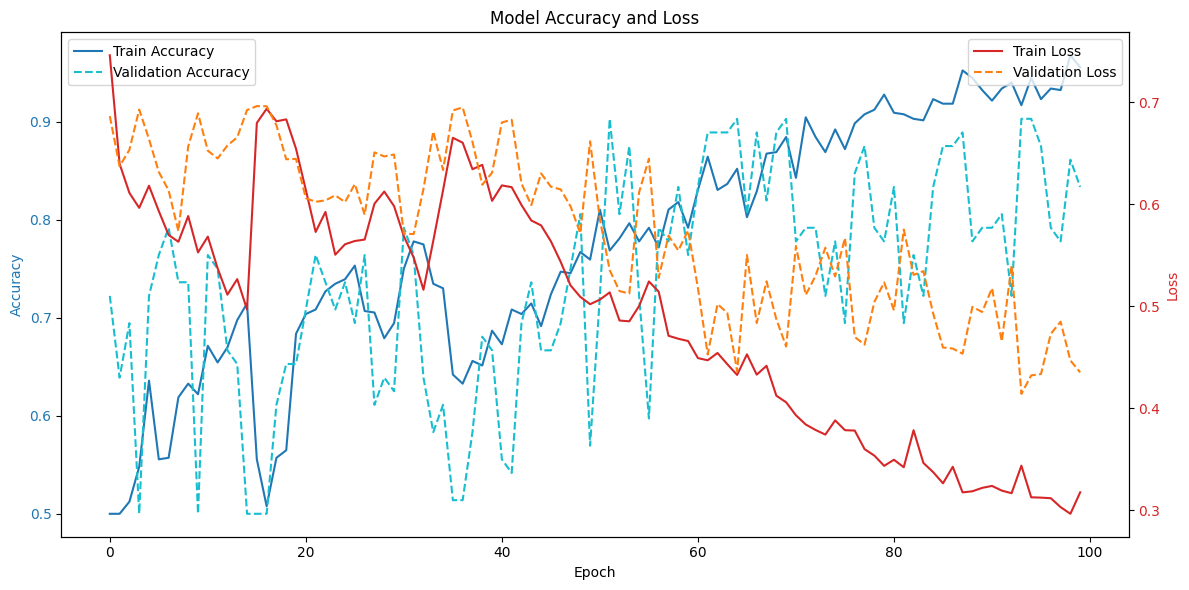

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot training & validation accuracy on the first y-axis
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(history.history['accuracy'], color='tab:blue', label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], color='tab:cyan', linestyle='--', label='Validation Accuracy')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Create a second y-axis for loss
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(history.history['loss'], color='tab:red', label='Train Loss')
ax2.plot(history.history['val_loss'], color='tab:orange', linestyle='--', label='Validation Loss')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')

# Title and layout
plt.title('Model Accuracy and Loss')
fig.tight_layout()
plt.show()